# How-to Guide: Scattering Workflows

This guide demonstrates how to use scattering in CWL workflows, allowing parallel execution of tasks on multiple inputs.

The focus is on the `ScatterFeatureRequirement` and `scatterMethod`.

## Objective

* Execute a subworkflow (rgb-composite) in parallel for multiple stac-items.
* Scatter the input stac-items to create multiple RGB composite outputs.

## Key Concepts

1. `ScatterFeatureRequirement`

The `ScatterFeatureRequirement` enables scattering, allowing a step to process multiple inputs in parallel.



In [1]:
cwl_file="../cwl-workflows/scatter-workflows.cwl"

cat $cwl_file | yq e .'$graph[0]' | yq '.. | select(has("ScatterFeatureRequirement")) | {"requirements": {"ScatterFeatureRequirement": .ScatterFeatureRequirement}}' 

requirements:
  ScatterFeatureRequirement: {}



This makes it possible to process an array of inputs independently, where each item is executed as a separate job.




2. `Scatter` and `ScatterMethod`

* `scatter`: Specifies the input field(s) to be scattered.
* `scatterMethod`: Defines how the inputs are combined when multiple fields are scattered: 
  * `dotproduct`: Matches corresponding elements of input arrays (e.g., the first element of each array is processed together).
  * `nested_crossproduct`: Creates a Cartesian product of inputs, producing combinations of all elements.
  * `flat_crossproduct`: Similar to `nested_crossproduct` but flattens the structure of results.

In [2]:
cat $cwl_file | yq e .'$graph[0].steps' -

step_rgb_composite:
  in:
    stac-item: stac-items
    bands: bands
  out:
    - rgb-tif
  run: "#rgb-composite"
  scatter: stac-item
  scatterMethod: dotproduct


* `scatter: stac-item`: The `stac-item` array is scattered, creating one subworkflow execution per item.
* `scatterMethod: dotproduct`: Matches each `stac-item` with the same bands input for each subworkflow execution.

## Steps

1. Define the Workflow

The main workflow (`scatter-workflows.cwl`) processes multiple stac-items in parallel:

Workflow Definition:



In [3]:
cat $cwl_file | yq e .'$graph[0]' -

class: Workflow
id: main
requirements:
  SubworkflowFeatureRequirement: {}
  InlineJavascriptRequirement: {}
  NetworkAccess:
    networkAccess: true
  ScatterFeatureRequirement: {}
inputs:
  stac-items:
    type: string[]
  bands:
    type: string[]
    default: ["red", "green", "blue"]
outputs:
  rgb-tif:
    outputSource: step_rgb_composite/rgb-tif
    type: File[]
steps:
  step_rgb_composite:
    in:
      stac-item: stac-items
      bands: bands
    out:
      - rgb-tif
    run: "#rgb-composite"
    scatter: stac-item
    scatterMethod: dotproduct


Its graphical representation:

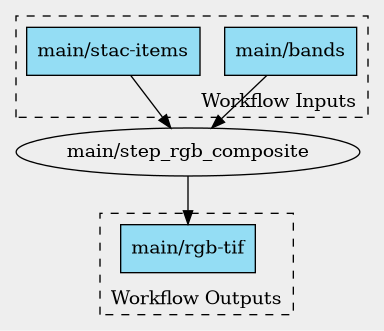

In [4]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

Inputs:

* `stac-items`: An array of URLs to STAC items.
* `bands`: Array of band names (`default: ["red", "green", "blue"]`).

Output:
* `rgb-tif`: An array of RGB TIFF files (one per `stac-item`).

Steps:

* `step_rgb_composite`: Calls the rgb-composite subworkflow with scattered stac-items.

2. Define the Subworkflow

The subworkflow (`rgb-composite`) processes a single stac-item to create an RGB composite:

Subworkflow Definition

In [5]:
cat $cwl_file | yq e .'$graph[1]' -

class: Workflow
id: rgb-composite
requirements:
  InlineJavascriptRequirement: {}
  NetworkAccess:
    networkAccess: true
  ScatterFeatureRequirement: {}
inputs:
  stac-item:
    type: string
  bands:
    type: string[]
outputs:
  rgb-tif:
    outputSource: step_color/rgb
    type: File
steps:
  step_curl:
    in:
      stac_item: stac-item
      common_band_name: bands
    out:
      - hrefs
    run: "#stac"
    scatter: common_band_name
    scatterMethod: dotproduct
  step_stack:
    in:
      tiffs:
        source: step_curl/hrefs
    out:
      - stacked
    run: "#rio_stack"
  step_color:
    in:
      stacked:
        source: step_stack/stacked
    out:
      - rgb
    run: "#rio_color"


Its graphical representation:

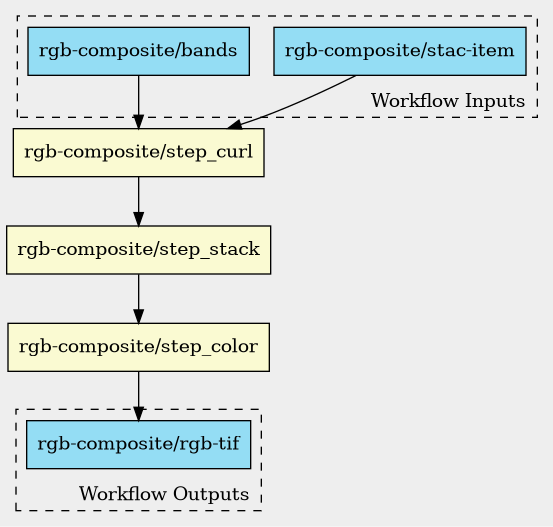

In [6]:
cwltool --print-dot $cwl_file#rgb-composite 2> /dev/null | dot -Tpng | display

Scatter in Subworkflow:

* `step_curl` scatters bands (e.g., `red`, `green`, `blue`).
* Each band is processed independently to retrieve its corresponding asset.

3. Run the Workflow

Execute the main workflow with multiple stac-items:

```bash
cwltool scatter-workflows.cwl \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_53HPA_20210728_0_L2A
```

In [7]:
cwltool $cwl_file \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2A_53HPA_20210728_0_L2A > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl-workflows/scatter-workflows.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl-workflows/scatter-workflows.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_rgb_composite
INFO [step step_rgb_composite] start
INFO [workflow step_rgb_composite] start
INFO [workflow step_rgb_composite] starting step step_curl
INFO [step step_curl] start
INFO [job step_curl] /tmp/s69s2to7$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/s69s2to7,target=/vaVMpy \
    --mount=type=bind,source=/tmp/8_xqs6_y,target=/tmp \
    --workdir=/vaVMpy \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/h8e5hbgw/20250102121437-177872.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/vaVMpy \
    docker.io/curlimages/curl:latest \
    curl \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A > /tmp/s69s2to7

4. Expected Output

The workflow creates an array of RGB composite TIFF files, one for each stac-item:

Output Files:
- rgb-tif[0]: RGB composite for the first stac-item.
- rgb-tif[1]: RGB composite for the second stac-item.

In [8]:
cat output.json | yq e . -o=json

{
  "rgb-tif": [
    {
      "location": "file:///data/work/github/eoepca-plus/how-to/docs/rgb.tif",
      "basename": "rgb.tif",
      "class": "File",
      "checksum": "sha1$904a76ccb42516e0af63996268f11424236e20ff",
      "size": 361747464,
      "path": "/data/work/github/eoepca-plus/how-to/docs/rgb.tif"
    },
    {
      "location": "file:///data/work/github/eoepca-plus/how-to/docs/rgb.tif_2",
      "basename": "rgb.tif",
      "class": "File",
      "checksum": "sha1$1358350a320f3c7489fd2f45ee30026b39c96259",
      "size": 361747464,
      "path": "/data/work/github/eoepca-plus/how-to/docs/rgb.tif_2"
    }
  ]
}


## Key Takeaways

1. `ScatterFeatureRequirement`:

* Enables parallel processing of array inputs.

2. Scatter and ScatterMethod:

* `scatter`: Specifies the input to scatter.
* `scatterMethod`:
  * `dotproduct`: Matches corresponding elements in input arrays.
  * `nested_crossproduct`: Generates all combinations of input elements.

3 .Scalable Workflows:

* Scattering simplifies large-scale processing by distributing tasks over multiple inputs, improving performance and modularity.

This guide demonstrates how scattering in CWL can streamline workflows by enabling parallel execution of steps on array inputs.

In [9]:
rm -f output.json
rm -f rgb.tif
rm -f rgb.tif_2